# Train stage

In this notebook we are going to train a model upon the basis of the data we have prepared in the previous notebook. We are going to test different models and hyperparameters to find the best model for our data. The goal is to predict the average trip duration of a route starting from a given point and ending at a given point.

In [1]:
import pandas as pd

df_train = pd.read_pickle('../data/train/inputs/travel_time_with_distances.pkl')

df_train.head(50)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,source_coordinates,dst_coordinates,source_dst,distance
0,360,563,10,1282.33,315.56,1246.33,1.27,"[-74.09962323366398, 4.6862625]","[-74.08758793333334, 4.7211485]","(360, 563)",7.5432
3,75,548,13,2043.50,377.27,2010.83,1.19,"[-74.03343874582688, 4.6849430000000005]","[-74.21490355950878, 4.625836]","(75, 548)",30.4357
4,1152,1131,0,514.12,383.08,428.93,1.74,"[-74.11164411332437, 4.677749]","[-74.18004646566523, 4.589392]","(1152, 1131)",18.3473
5,1151,1141,0,399.07,208.18,361.21,1.53,"[-74.09159054158111, 4.707669]","[-74.21120185102613, 4.6119699999999995]","(1151, 1141)",20.7577
6,351,653,10,1763.42,396.84,1721.73,1.24,"[-74.06838855415091, 4.692584]","[-74.0373346847826, 4.6808475000000005]","(351, 653)",4.3633
8,249,579,19,1002.90,226.87,980.59,1.23,"[-74.02701123319892, 4.7010275]","[-74.0517806824, 4.689227000000001]","(249, 579)",5.9572
10,208,989,19,3045.13,546.94,2998.96,1.19,"[-74.08096978488952, 4.5989629999999995]","[-74.10481560105384, 4.4966245]","(208, 989)",16.2106
12,229,779,19,1641.43,521.64,1571.69,1.33,"[-74.02619886534885, 4.7057535]","[-74.1162250865878, 4.5789930000000005]","(229, 779)",21.4881
13,248,589,19,2859.06,348.85,2837.89,1.13,"[-74.06751697305393, 4.6250105]","[-74.08047553591874, 4.498937]","(248, 589)",17.8996
14,352,643,10,2066.40,556.86,1993.84,1.30,"[-74.06551585314207, 4.6530125]","[-74.12225614990808, 4.6348769999999995]","(352, 643)",11.6116


In [2]:
# separate the values in the columns source coordinates and destination coordinates into two columns each with the latitude and longitude

df_train[['source_lon', 'source_lat']] = pd.DataFrame(df_train['source_coordinates'].tolist(), index=df_train.index)
df_train[['destination_lon', 'destination_lat']] = pd.DataFrame(df_train['dst_coordinates'].tolist(), index=df_train.index)
df_train.drop(columns=['source_coordinates', 'dst_coordinates'], inplace=True)
df_train.dropna(subset=['distance'], inplace=True)

In [3]:
# creates a pipeline to cross validate the models

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# import linear regression model
from sklearn.linear_model import LinearRegression
# import random forest regressor model
from sklearn.ensemble import RandomForestRegressor


X = df_train[['source_lon', 'source_lat', 'destination_lon', 'destination_lat', 'distance','hod']]
y = df_train['mean_travel_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




In [4]:
X

,source_lon,source_lat,destination_lon,destination_lat,distance,hod
0,-74.099623,4.686262,-74.087588,4.721148,7.5432,10
3,-74.033439,4.684943,-74.214904,4.625836,30.4357,13
4,-74.111644,4.677749,-74.180046,4.589392,18.3473,0
5,-74.091591,4.707669,-74.211202,4.611970,20.7577,0
6,-74.068389,4.692584,-74.037335,4.680848,4.3633,10
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,11.2067,15
7060938,-74.109216,4.592483,-74.154047,4.543817,11.7154,5
7060939,-74.135737,4.656237,-74.155440,4.678437,4.6314,5
7060941,-74.135683,4.581468,-74.084660,4.722879,20.7584,18


In [5]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

param_grid = {
    'model': [KNeighborsRegressor()],
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}


In [6]:
# apply an ordinary linear regression model to the data
pipe = Pipeline([('scaler', MinMaxScaler()), ('model', LinearRegression())])
                 
# apply the pipeline to the data
pipe.fit(X_train, y_train)
# make predictions
y_pred = pipe.predict(X_test)
# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse} and RMSE: {mse**0.5}')

Mean Squared Error: 713593.3350120293 and RMSE: 844.7445383144121


In [14]:
# score is the mean squared error

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'model': KNeighborsRegressor(), 'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'distance'}
0.48110385340717954


In [8]:
# predict the values of the test set
# params
# k =5
# weights = distance
# p = 1

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsRegressor(n_neighbors=5, weights='distance', p=1))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse} and RMSE: {mse**0.5}')

# pipe to pickle the model
import pickle
with open('../data/train/models/knn_model.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Mean Squared Error: 445739.6861537419 and RMSE: 667.6373912190223


In [9]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor())
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse} and RMSE: {mse**0.5}')

with open('../data/train/models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Mean Squared Error: 367745.27779493993 and RMSE: 606.4200506208052


In [18]:
# run a modelo using XGBoost
from xgboost import XGBRegressor
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse} and RMSE: {mse**0.5}')


Mean Squared Error: 522944.04173776106 and RMSE: 723.1486996031737


In [19]:
# cross validation with xgboost

param_grid = {
    'model': [XGBRegressor()],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3]
}

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor())
])

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.cv_results_)
print(grid.cv_results_['mean_test_score'])






Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'model__learning_rate': 0.3, 'model__max_depth': 7, 'model__n_estimators': 300}
0.4081020289470009
{'mean_fit_time': array([ 71.03551855, 123.91848221, 165.77485948,  85.56498051,


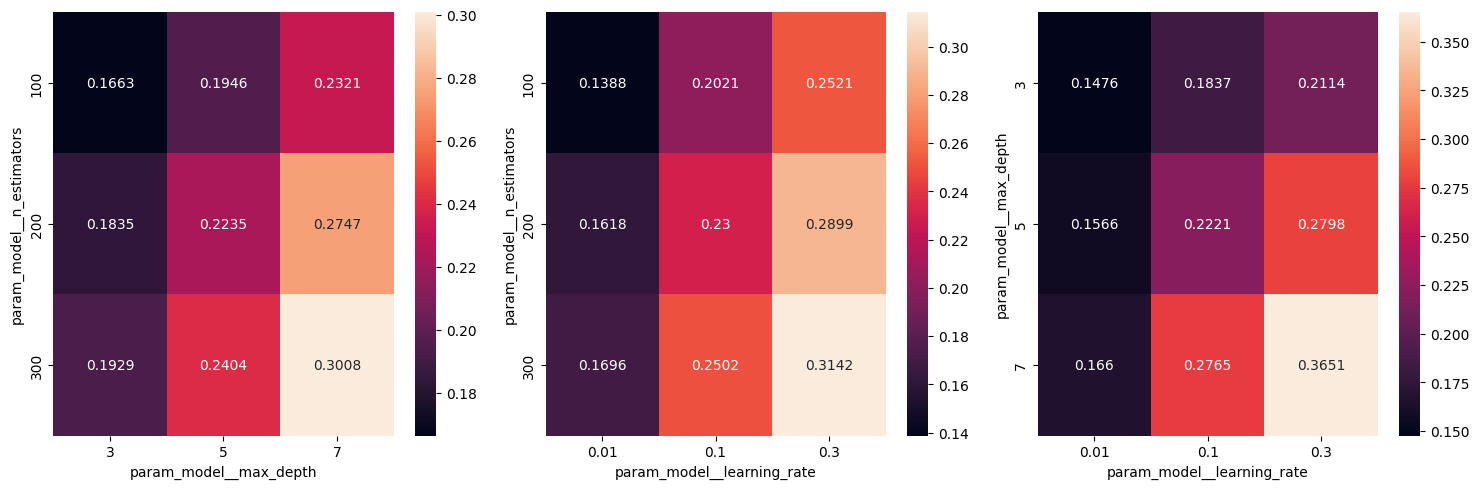

In [21]:
#plot the results of the grid search
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.DataFrame(grid.cv_results_)
results['param_model__n_estimators'] = results['param_model__n_estimators'].astype(int)
results['param_model__max_depth'] = results['param_model__max_depth'].astype(int)
results['param_model__learning_rate'] = results['param_model__learning_rate'].astype(float)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(results.pivot_table(index='param_model__n_estimators', columns='param_model__max_depth', values='mean_test_score'), annot=True, fmt='.4g', ax=ax[0])
sns.heatmap(results.pivot_table(index='param_model__n_estimators', columns='param_model__learning_rate', values='mean_test_score'), annot=True, fmt='.4g', ax=ax[1])
sns.heatmap(results.pivot_table(index='param_model__max_depth', columns='param_model__learning_rate', values='mean_test_score'), annot=True, fmt='.4g', ax=ax[2])
plt.tight_layout()
plt.show()




In [20]:
mean_squared_error(y_test, grid.predict(X_test))

430163.8063670487

In [5]:
import xgboost as xgb
import hyperopt as hpopt
import numpy as np

# Define the hyperparameter space

space = {
    
    'n_estimators': hpopt.hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hpopt.hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'learning_rate': hpopt.hp.uniform('learning_rate', 0.01, 0.3)
}



# Define the objective function

def objective(params):
    model = xgb.XGBRegressor(**params)
    #model = model = xgb.XGBRFRegressor(**params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Evaluating model with params: {params}")
    return mean_squared_error(y_test, y_pred)**0.5


# Run the hyperparameter search

best = hpopt.fmin(fn=objective, space=space, algo=hpopt.tpe.suggest, max_evals=100)


Evaluating model with params: {'learning_rate': 0.020454058177092928, 'max_depth': 4, 'n_estimators': 449}
Evaluating model with params: {'learning_rate': 0.02018131834669265, 'max_depth': 6, 'n_estimators': 630}
Evaluating model with params: {'learning_rate': 0.038473405783931394, 'max_depth': 9, 'n_estimators': 265}
Evaluating model with params: {'learning_rate': 0.1676889676374816, 'max_depth': 4, 'n_estimators': 492}
Evaluating model with params: {'learning_rate': 0.22975700357310436, 'max_depth': 3, 'n_estimators': 173}
Evaluating model with params: {'learning_rate': 0.010088366254744349, 'max_depth': 4, 'n_estimators': 132}
Evaluating model with params: {'learning_rate': 0.1925588740145215, 'max_depth': 9, 'n_estimators': 392}
Evaluating model with params: {'learning_rate': 0.030975143941275055, 'max_depth': 7, 'n_estimators': 684}
Evaluating model with params: {'learning_rate': 0.06864515564708999, 'max_depth': 9, 'n_estimators': 834}
Evaluating model with params: {'learning_rat

In [8]:
# export the model with the best params to pickle

import pickle
import os

os.makedirs('../data/train/models', exist_ok=True)

pipe = Pipeline([
    ('model', xgb.XGBRegressor(n_estimators=best['n_estimators'], max_depth=best['max_depth'], learning_rate=best['learning_rate']))
])

pipe.fit(X_train, y_train)
with open('../data/train/models/xgboos_v1.pkl', 'wb') as f:
    pickle.dump(pipe, f)



In [12]:
# summarise the results

print(best)

# evaluate the model with the best params

model = xgb.XGBRegressor(n_estimators=best['n_estimators'], max_depth=best['max_depth'], learning_rate=best['learning_rate'])
model.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse} and RMSE: {mse**0.5}')



{'learning_rate': 0.2618500766372146, 'max_depth': 6, 'n_estimators': 815}
Mean Squared Error: 413264.5665985115 and RMSE: 642.8565676716008
